<a href="https://colab.research.google.com/github/ndb796/PyTorch-Adversarial-Attack-Baselines-for-ImageNet-CIFAR10-MNIST/blob/main/PyTorch_Linf_PGD_Untargeted_Attack_using_ImageNet_Images.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### <b>Load Required Libraries</b>

In [1]:
!git clone https://github.com/ndb796/PyTorch-Adversarial-Attack-Baselines-for-ImageNet-CIFAR10-MNIST
%cd PyTorch-Adversarial-Attack-Baselines-for-ImageNet-CIFAR10-MNIST/datasets

Cloning into 'PyTorch-Adversarial-Attack-Baselines-for-ImageNet-CIFAR10-MNIST'...
remote: Enumerating objects: 54, done.
remote: Counting objects: 100% (54/54), done.
remote: Compressing objects: 100% (54/54), done.
remote: Total 6068 (delta 30), reused 0 (delta 0), pack-reused 6014
Receiving objects: 100% (6068/6068), 630.79 MiB | 22.92 MiB/s, done.
Resolving deltas: 100% (31/31), done.
Checking out files: 100% (5006/5006), done.
/content/PyTorch-Adversarial-Attack-Baselines-for-ImageNet-CIFAR10-MNIST/datasets


In [2]:
# load required PyTorch libraries
import torch
import torch.nn as nn
import torchvision.transforms as transforms

In [3]:
use_cuda = True
device = torch.device("cuda" if use_cuda else "cpu")

#### <b>Load ImageNet Classes</b>

In [4]:
from urllib.request import urlretrieve
import json

# load 1,000 labels from the ImageNet config file
with open('./imagenet.json') as f:
    imagenet_labels = json.load(f)

print(imagenet_labels[18])

magpie


#### <b>Image Visualization</b>

In [5]:
imsize = 224

preprocess = transforms.Compose([
    transforms.Resize((imsize, imsize)), # resize the image size
    transforms.ToTensor(), # [0, 255] → [0, 1] torch.Tensor
])

In [6]:
# load an image visualization library
import matplotlib.pyplot as plt
import PIL

plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 60
plt.rcParams.update({'font.size': 20})

In [7]:
# load an image and get a torch.Tensor object
def image_loader(path):
    image = PIL.Image.open(path)
    image = preprocess(image).unsqueeze(0) # [1, 3, H, W]
    return image.to(device, torch.float)

In [8]:
image = image_loader('./ILSVRC2012_img_val_subset/18/ILSVRC2012_val_00000476.JPEG')

In [9]:
# show torch.Tensor image
def imshow(tensor):
    image = tensor.cpu().clone()
    image = image.squeeze(0) # [3, H, W]
    image = transforms.ToPILImage()(image)
    # show an image whose values are between [0, 1]
    plt.imshow(image)
    plt.show()

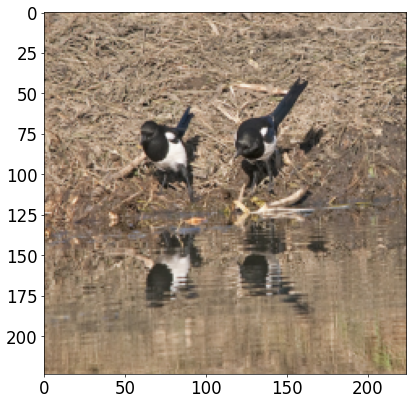

In [10]:
imshow(image)

#### <b>Load Pre-trained Classification Model</b>

In [11]:
# input data normalization class
class Normalize(nn.Module) :
    def __init__(self, mean, std) :
        super(Normalize, self).__init__()
        self.register_buffer('mean', torch.Tensor(mean))
        self.register_buffer('std', torch.Tensor(std))
        
    def forward(self, input):
        mean = self.mean.reshape(1, 3, 1, 1)
        std = self.std.reshape(1, 3, 1, 1)
        return (input - mean) / std

In [12]:
model = nn.Sequential(
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), # add an input normalization layer
    torch.hub.load('pytorch/vision:v0.6.0', 'resnet50', pretrained=True)
).to(device).eval()

Downloading: "https://github.com/pytorch/vision/archive/v0.6.0.zip" to /root/.cache/torch/hub/v0.6.0.zip
Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


In [20]:
outputs = model(image)
percentages = torch.nn.functional.softmax(outputs, dim=1)[0] * 100
print("< Highest Confidence Classes >")
for i in outputs[0].topk(5)[1]:
    print(f"Index: {i.item()} / Class name: {imagenet_labels[i]} / Probability: {round(percentages[i].item(), 4)}%")

< Highest Confidence Classes >
Index: 18 / Class name: magpie / Probability: 76.3741%
Index: 80 / Class name: black grouse / Probability: 17.3179%
Index: 137 / Class name: American coot, marsh hen, mud hen, water hen, Fulica americana / Probability: 1.0765%
Index: 93 / Class name: hornbill / Probability: 0.6028%
Index: 128 / Class name: black stork, Ciconia nigra / Probability: 0.5908%


#### <b>Load Validation Dataset</b>

In [21]:
import os
from torchvision import datasets

data_dir = './ILSVRC2012_img_val_subset'

val_dataset = datasets.ImageFolder(os.path.join(data_dir), preprocess)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=16, shuffle=True, num_workers=2)
print('Validation dataset size:', len(val_dataset))

class_names = val_dataset.classes
print('The number of classes:', len(class_names))

Validation dataset size: 5000
The number of classes: 1000


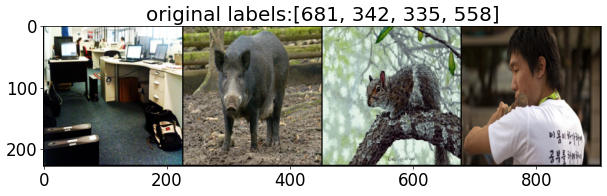

Original labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #1: notebook, notebook computer (681)
Image #2: wild boar, boar, Sus scrofa (342)
Image #3: fox squirrel, eastern fox squirrel, Sciurus niger (335)
Image #4: flute, transverse flute (558)


In [22]:
import torchvision
import numpy as np


def imshow_batch(input, title):
    # torch.Tensor => numpy
    input = input.numpy().transpose((1, 2, 0))
    # display images
    plt.imshow(input)
    plt.title(title)
    plt.show()


# load a batch of validation image
iterator = iter(val_dataloader)

# visualize a batch of validation image
inputs, classes = next(iterator)
out = torchvision.utils.make_grid(inputs[:4])
imshow_batch(out, title='original labels:' + str([int(class_names[x]) for x in classes[:4]]))

print('Original labels >>>>>>>>>>>>>>>>>>>>>>>>>')
for i, x in enumerate(classes[:4]):
    imagenet_index = int(class_names[x])
    label = imagenet_labels[imagenet_index]
    print(f'Image #{i + 1}: {label} ({imagenet_index})')

#### <b>Validation Phase</b>

[Prediction Result Examples]


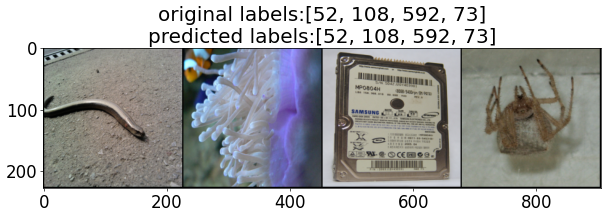

Original labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #1: thunder snake, worm snake, Carphophis amoenus (52)
Image #2: sea anemone, anemone (108)
Image #3: hard disc, hard disk, fixed disk (592)
Image #4: barn spider, Araneus cavaticus (73)
Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #1: thunder snake, worm snake, Carphophis amoenus (52)
Image #2: sea anemone, anemone (108)
Image #3: hard disc, hard disk, fixed disk (592)
Image #4: barn spider, Araneus cavaticus (73)


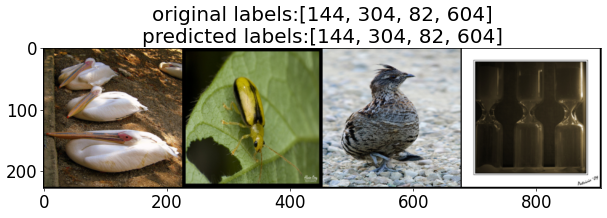

Original labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #5: pelican (144)
Image #6: leaf beetle, chrysomelid (304)
Image #7: ruffed grouse, partridge, Bonasa umbellus (82)
Image #8: hourglass (604)
Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #5: pelican (144)
Image #6: leaf beetle, chrysomelid (304)
Image #7: ruffed grouse, partridge, Bonasa umbellus (82)
Image #8: hourglass (604)
[Validation] Loss: 0.0619 Accuracy: 76.0600% Time elapsed: 46.5989s (total 5000 images)


In [23]:
import time

criterion = nn.CrossEntropyLoss()
model.eval()
start_time = time.time()

with torch.no_grad():
    running_loss = 0.
    running_corrects = 0

    for i, (inputs, basic_labels) in enumerate(val_dataloader):
        inputs = inputs.to(device)
        labels = torch.zeros_like(basic_labels).to(device)
        for j in range(labels.shape[0]):
            labels[j] = int(class_names[basic_labels[j]])
        labels = labels.to(device)

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        running_loss += loss.item()
        running_corrects += torch.sum(preds == labels.data)

        if i == 0:
            print('[Prediction Result Examples]')
            images = torchvision.utils.make_grid(inputs[:4])
            imshow_batch(images.cpu(), title='original labels:' + str([int(x) for x in labels[:4]]) +
                         '\npredicted labels:' + str([int(x) for x in preds[:4]]))
            print('Original labels >>>>>>>>>>>>>>>>>>>>>>>>>')
            for j, imagenet_index in enumerate(labels[:4]):
                label = imagenet_labels[imagenet_index]
                print(f'Image #{j + 1}: {label} ({imagenet_index})')
            print('Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>')
            for j, imagenet_index in enumerate(preds[:4]):
                label = imagenet_labels[imagenet_index]
                print(f'Image #{j + 1}: {label} ({imagenet_index})')
            images = torchvision.utils.make_grid(inputs[4:8])
            imshow_batch(images.cpu(), title='original labels:' + str([int(x) for x in labels[4:8]]) +
                         '\npredicted labels:' + str([int(x) for x in preds[4:8]]))
            print('Original labels >>>>>>>>>>>>>>>>>>>>>>>>>')
            for j, imagenet_index in enumerate(labels[4:8]):
                label = imagenet_labels[imagenet_index]
                print(f'Image #{j + 5}: {label} ({imagenet_index})')
            print('Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>')
            for j, imagenet_index in enumerate(preds[4:8]):
                label = imagenet_labels[imagenet_index]
                print(f'Image #{j + 5}: {label} ({imagenet_index})')

    epoch_loss = running_loss / len(val_dataset)
    epoch_acc = running_corrects / len(val_dataset) * 100.
    print('[Validation] Loss: {:.4f} Accuracy: {:.4f}% Time elapsed: {:.4f}s (total {} images)'.format(epoch_loss, epoch_acc, time.time() - start_time, len(val_dataset)))

#### <b>Prepare Adversarial Attack Libraries</b>

In [27]:
!pip install foolbox
!pip install advertorch

In [28]:
def get_distance(a, b):
    l0 = torch.norm((a - b).view(a.shape[0], -1), p=0, dim=1)
    l2 = torch.norm((a - b).view(a.shape[0], -1), p=2, dim=1)
    mse = (a - b).view(a.shape[0], -1).pow(2).mean(1)
    linf = torch.norm((a - b).view(a.shape[0], -1), p=float('inf'), dim=1)
    return l0, l2, mse, linf

#### <b>Adversarial Attack Example 1</b>

* <b>Attack method</b>: 4-step Linf PGD
* <b>Images</b>: 5,000 valiation images
* <b>Epsilon size</b>: 1 / 255

The dimension of an image tensor: torch.Size([3, 224, 224])
[Prediction Result Examples]


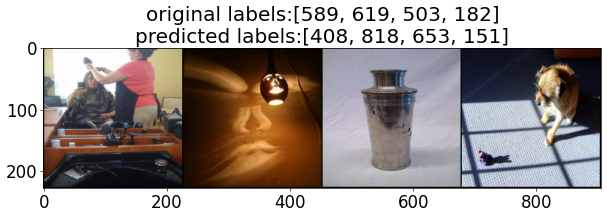

Original labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #1: hand blower, blow dryer, blow drier, hair dryer, hair drier (589)
Image #2: lampshade, lamp shade (619)
Image #3: cocktail shaker (503)
Image #4: Border terrier (182)
Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #1: amphibian, amphibious vehicle (408)
Image #2: spotlight, spot (818)
Image #3: milk can (653)
Image #4: Chihuahua (151)


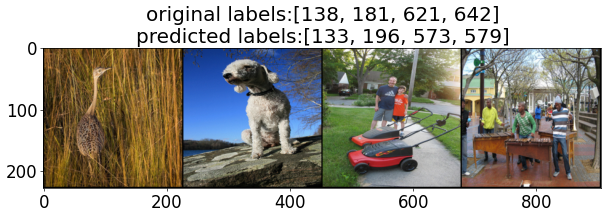

Original labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #5: bustard (138)
Image #6: Bedlington terrier (181)
Image #7: lawn mower, mower (621)
Image #8: marimba, xylophone (642)
Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #5: bittern (133)
Image #6: miniature schnauzer (196)
Image #7: go-kart (573)
Image #8: grand piano, grand (579)
[Step #0] Loss: 0.9584 Accuracy: 0.0000% Time elapsed: 2.5725s (total 16 images)
[Step #10] Loss: 0.9550 Accuracy: 0.0000% Time elapsed: 18.7898s (total 176 images)
[Step #20] Loss: 0.9250 Accuracy: 1.1905% Time elapsed: 34.9715s (total 336 images)
[Step #30] Loss: 0.9390 Accuracy: 1.2097% Time elapsed: 51.1698s (total 496 images)
[Step #40] Loss: 0.9323 Accuracy: 1.3720% Time elapsed: 67.3469s (total 656 images)
[Step #50] Loss: 0.9378 Accuracy: 1.3480% Time elapsed: 83.4751s (total 816 images)
[Step #60] Loss: 0.9322 Accuracy: 1.3320% Time elapsed: 99.6037s (total 976 images)
[Step #70] Loss: 0.9330 Accuracy: 1.1444% Time elapsed: 115.7119s (total 1136 image

In [29]:
import time
from advertorch.attacks import LinfPGDAttack

criterion = nn.CrossEntropyLoss()
model.eval()
start_time = time.time()

adversary = LinfPGDAttack(
    model, loss_fn=nn.CrossEntropyLoss(reduction="sum"),
    eps=1/255, nb_iter=4, eps_iter=1/255/2, clip_min=0.0, clip_max=1.0, targeted=False)

running_loss = 0.
running_corrects = 0
running_length = 0

running_l0 = 0
running_l2 = 0
running_mse = 0
running_linf = 0

for i, (inputs, basic_labels) in enumerate(val_dataloader):
    inputs = inputs.to(device)
    labels = torch.zeros_like(basic_labels).long().to(device)
    for j in range(labels.shape[0]):
        labels[j] = int(class_names[basic_labels[j]])
    labels = labels.to(device)

    adv_untargeted = adversary.perturb(inputs, labels) # adversarial attack

    outputs = model(adv_untargeted)
    _, preds = torch.max(outputs, 1)
    loss = criterion(outputs, labels)

    running_loss += loss.item()
    running_corrects += torch.sum(preds == labels.data)
    running_length += labels.shape[0]

    l0, l2, mse, linf = get_distance(adv_untargeted, inputs)
    running_l0 += l0.sum().item()
    running_l2 += l2.sum().item()
    running_mse += mse.sum().item()
    running_linf += linf.sum().item()

    if i == 0:
        print('The dimension of an image tensor:', inputs.shape[1:])
        print('[Prediction Result Examples]')
        images = torchvision.utils.make_grid(adv_untargeted[:4])
        imshow_batch(images.cpu(), title='original labels:' + str([int(x) for x in labels[:4]]) +
                      '\npredicted labels:' + str([int(x) for x in preds[:4]]))
        print('Original labels >>>>>>>>>>>>>>>>>>>>>>>>>')
        for j, imagenet_index in enumerate(labels[:4]):
            label = imagenet_labels[imagenet_index]
            print(f'Image #{j + 1}: {label} ({imagenet_index})')
        print('Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>')
        for j, imagenet_index in enumerate(preds[:4]):
            label = imagenet_labels[imagenet_index]
            print(f'Image #{j + 1}: {label} ({imagenet_index})')
        images = torchvision.utils.make_grid(adv_untargeted[4:8])
        imshow_batch(images.cpu(), title='original labels:' + str([int(x) for x in labels[4:8]]) +
                      '\npredicted labels:' + str([int(x) for x in preds[4:8]]))
        print('Original labels >>>>>>>>>>>>>>>>>>>>>>>>>')
        for j, imagenet_index in enumerate(labels[4:8]):
            label = imagenet_labels[imagenet_index]
            print(f'Image #{j + 5}: {label} ({imagenet_index})')
        print('Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>')
        for j, imagenet_index in enumerate(preds[4:8]):
            label = imagenet_labels[imagenet_index]
            print(f'Image #{j + 5}: {label} ({imagenet_index})')

    if i % 10 == 0:
        cur_running_loss = running_loss / running_length
        running_acc = running_corrects / running_length * 100.
        print('[Step #{}] Loss: {:.4f} Accuracy: {:.4f}% Time elapsed: {:.4f}s (total {} images)'.format(i, cur_running_loss, running_acc, time.time() - start_time, running_length))

epoch_loss = running_loss / len(val_dataset)
epoch_acc = running_corrects / len(val_dataset) * 100.
print('[Validation] Loss: {:.4f} Accuracy: {:.4f}% Time elapsed: {:.4f}s (total {} images)'.format(epoch_loss, epoch_acc, time.time() - start_time, len(val_dataset)))

print('[Size of Perturbation]')
print('Average L0 distance (the number of changed parameters):', running_l0 / len(val_dataset))
print('Average L2 distance:', running_l2 / len(val_dataset))
print('Average MSE:', running_mse / len(val_dataset))
print('Average Linf distance (the maximum changed values):', running_linf / len(val_dataset))

#### <b>Adversarial Attack Example 2</b>

* <b>Attack method</b>: 7-step Linf PGD
* <b>Images</b>: 5,000 valiation images
* <b>Epsilon size</b>: 1 / 255

The dimension of an image tensor: torch.Size([3, 224, 224])
[Prediction Result Examples]


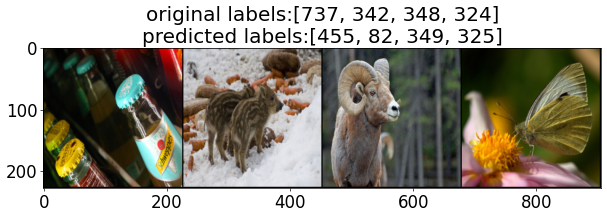

Original labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #1: pop bottle, soda bottle (737)
Image #2: wild boar, boar, Sus scrofa (342)
Image #3: ram, tup (348)
Image #4: cabbage butterfly (324)
Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #1: bottlecap (455)
Image #2: ruffed grouse, partridge, Bonasa umbellus (82)
Image #3: bighorn, bighorn sheep, cimarron, Rocky Mountain bighorn, Rocky Mountain sheep, Ovis canadensis (349)
Image #4: sulphur butterfly, sulfur butterfly (325)


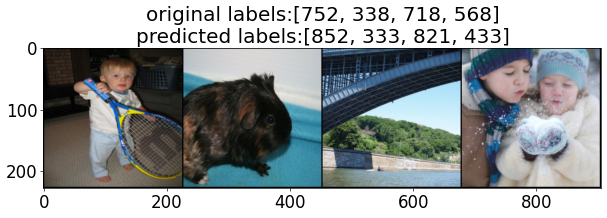

Original labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #5: racket, racquet (752)
Image #6: guinea pig, Cavia cobaya (338)
Image #7: pier (718)
Image #8: fur coat (568)
Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #5: tennis ball (852)
Image #6: hamster (333)
Image #7: steel arch bridge (821)
Image #8: bathing cap, swimming cap (433)
[Step #0] Loss: 1.1013 Accuracy: 0.0000% Time elapsed: 3.7385s (total 16 images)
[Step #10] Loss: 1.2080 Accuracy: 1.1364% Time elapsed: 30.9865s (total 176 images)
[Step #20] Loss: 1.1719 Accuracy: 0.8929% Time elapsed: 58.2288s (total 336 images)
[Step #30] Loss: 1.1455 Accuracy: 0.6048% Time elapsed: 85.4612s (total 496 images)
[Step #40] Loss: 1.1197 Accuracy: 0.4573% Time elapsed: 112.6866s (total 656 images)
[Step #50] Loss: 1.1184 Accuracy: 0.3676% Time elapsed: 139.9091s (total 816 images)
[Step #60] Loss: 1.1149 Accuracy: 0.4098% Time elapsed: 167.1347s (total 976 images)
[Step #70] Loss: 1.1128 Accuracy: 0.4401% Time elapsed: 194.3707s (total 1136 im

In [30]:
import time
from advertorch.attacks import LinfPGDAttack

criterion = nn.CrossEntropyLoss()
model.eval()
start_time = time.time()

adversary = LinfPGDAttack(
    model, loss_fn=nn.CrossEntropyLoss(reduction="sum"),
    eps=1/255, nb_iter=7, eps_iter=1/255/4, clip_min=0.0, clip_max=1.0, targeted=False)

running_loss = 0.
running_corrects = 0
running_length = 0

running_l0 = 0
running_l2 = 0
running_mse = 0
running_linf = 0

for i, (inputs, basic_labels) in enumerate(val_dataloader):
    inputs = inputs.to(device)
    labels = torch.zeros_like(basic_labels).long().to(device)
    for j in range(labels.shape[0]):
        labels[j] = int(class_names[basic_labels[j]])
    labels = labels.to(device)

    adv_untargeted = adversary.perturb(inputs, labels) # adversarial attack

    outputs = model(adv_untargeted)
    _, preds = torch.max(outputs, 1)
    loss = criterion(outputs, labels)

    running_loss += loss.item()
    running_corrects += torch.sum(preds == labels.data)
    running_length += labels.shape[0]

    l0, l2, mse, linf = get_distance(adv_untargeted, inputs)
    running_l0 += l0.sum().item()
    running_l2 += l2.sum().item()
    running_mse += mse.sum().item()
    running_linf += linf.sum().item()

    if i == 0:
        print('The dimension of an image tensor:', inputs.shape[1:])
        print('[Prediction Result Examples]')
        images = torchvision.utils.make_grid(adv_untargeted[:4])
        imshow_batch(images.cpu(), title='original labels:' + str([int(x) for x in labels[:4]]) +
                      '\npredicted labels:' + str([int(x) for x in preds[:4]]))
        print('Original labels >>>>>>>>>>>>>>>>>>>>>>>>>')
        for j, imagenet_index in enumerate(labels[:4]):
            label = imagenet_labels[imagenet_index]
            print(f'Image #{j + 1}: {label} ({imagenet_index})')
        print('Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>')
        for j, imagenet_index in enumerate(preds[:4]):
            label = imagenet_labels[imagenet_index]
            print(f'Image #{j + 1}: {label} ({imagenet_index})')
        images = torchvision.utils.make_grid(adv_untargeted[4:8])
        imshow_batch(images.cpu(), title='original labels:' + str([int(x) for x in labels[4:8]]) +
                      '\npredicted labels:' + str([int(x) for x in preds[4:8]]))
        print('Original labels >>>>>>>>>>>>>>>>>>>>>>>>>')
        for j, imagenet_index in enumerate(labels[4:8]):
            label = imagenet_labels[imagenet_index]
            print(f'Image #{j + 5}: {label} ({imagenet_index})')
        print('Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>')
        for j, imagenet_index in enumerate(preds[4:8]):
            label = imagenet_labels[imagenet_index]
            print(f'Image #{j + 5}: {label} ({imagenet_index})')

    if i % 10 == 0:
        cur_running_loss = running_loss / running_length
        running_acc = running_corrects / running_length * 100.
        print('[Step #{}] Loss: {:.4f} Accuracy: {:.4f}% Time elapsed: {:.4f}s (total {} images)'.format(i, cur_running_loss, running_acc, time.time() - start_time, running_length))

epoch_loss = running_loss / len(val_dataset)
epoch_acc = running_corrects / len(val_dataset) * 100.
print('[Validation] Loss: {:.4f} Accuracy: {:.4f}% Time elapsed: {:.4f}s (total {} images)'.format(epoch_loss, epoch_acc, time.time() - start_time, len(val_dataset)))

print('[Size of Perturbation]')
print('Average L0 distance (the number of changed parameters):', running_l0 / len(val_dataset))
print('Average L2 distance:', running_l2 / len(val_dataset))
print('Average MSE:', running_mse / len(val_dataset))
print('Average Linf distance (the maximum changed values):', running_linf / len(val_dataset))

#### <b>Adversarial Attack Example 3</b>

* <b>Attack method</b>: 4-step Linf PGD
* <b>Images</b>: 5,000 valiation images
* <b>Epsilon size</b>: 2 / 255

The dimension of an image tensor: torch.Size([3, 224, 224])
[Prediction Result Examples]


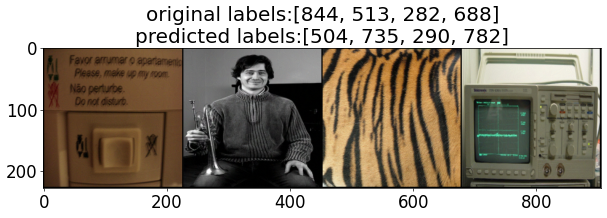

Original labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #1: switch, electric switch, electrical switch (844)
Image #2: cornet, horn, trumpet, trump (513)
Image #3: tiger cat (282)
Image #4: oscilloscope, scope, cathode-ray oscilloscope, CRO (688)
Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #1: coffee mug (504)
Image #2: poncho (735)
Image #3: jaguar, panther, Panthera onca, Felis onca (290)
Image #4: screen, CRT screen (782)


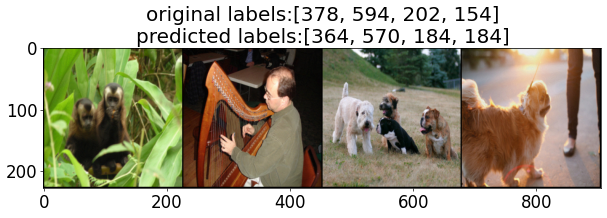

Original labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #5: capuchin, ringtail, Cebus capucinus (378)
Image #6: harp (594)
Image #7: soft-coated wheaten terrier (202)
Image #8: Pekinese, Pekingese, Peke (154)
Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #5: three-toed sloth, ai, Bradypus tridactylus (364)
Image #6: gasmask, respirator, gas helmet (570)
Image #7: Irish terrier (184)
Image #8: Irish terrier (184)
[Step #0] Loss: 1.3682 Accuracy: 0.0000% Time elapsed: 2.4733s (total 16 images)
[Step #10] Loss: 1.3568 Accuracy: 0.0000% Time elapsed: 18.5933s (total 176 images)
[Step #20] Loss: 1.3176 Accuracy: 0.0000% Time elapsed: 34.7257s (total 336 images)
[Step #30] Loss: 1.3332 Accuracy: 0.2016% Time elapsed: 50.8360s (total 496 images)
[Step #40] Loss: 1.3307 Accuracy: 0.1524% Time elapsed: 66.9767s (total 656 images)
[Step #50] Loss: 1.3166 Accuracy: 0.1225% Time elapsed: 83.1049s (total 816 images)
[Step #60] Loss: 1.3238 Accuracy: 0.1025% Time elapsed: 99.2332s (total 976 images)
[Ste

In [31]:
import time
from advertorch.attacks import LinfPGDAttack

criterion = nn.CrossEntropyLoss()
model.eval()
start_time = time.time()

adversary = LinfPGDAttack(
    model, loss_fn=nn.CrossEntropyLoss(reduction="sum"),
    eps=2/255, nb_iter=4, eps_iter=2/255/2, clip_min=0.0, clip_max=1.0, targeted=False)

running_loss = 0.
running_corrects = 0
running_length = 0

running_l0 = 0
running_l2 = 0
running_mse = 0
running_linf = 0

for i, (inputs, basic_labels) in enumerate(val_dataloader):
    inputs = inputs.to(device)
    labels = torch.zeros_like(basic_labels).long().to(device)
    for j in range(labels.shape[0]):
        labels[j] = int(class_names[basic_labels[j]])
    labels = labels.to(device)

    adv_untargeted = adversary.perturb(inputs, labels) # adversarial attack

    outputs = model(adv_untargeted)
    _, preds = torch.max(outputs, 1)
    loss = criterion(outputs, labels)

    running_loss += loss.item()
    running_corrects += torch.sum(preds == labels.data)
    running_length += labels.shape[0]

    l0, l2, mse, linf = get_distance(adv_untargeted, inputs)
    running_l0 += l0.sum().item()
    running_l2 += l2.sum().item()
    running_mse += mse.sum().item()
    running_linf += linf.sum().item()

    if i == 0:
        print('The dimension of an image tensor:', inputs.shape[1:])
        print('[Prediction Result Examples]')
        images = torchvision.utils.make_grid(adv_untargeted[:4])
        imshow_batch(images.cpu(), title='original labels:' + str([int(x) for x in labels[:4]]) +
                      '\npredicted labels:' + str([int(x) for x in preds[:4]]))
        print('Original labels >>>>>>>>>>>>>>>>>>>>>>>>>')
        for j, imagenet_index in enumerate(labels[:4]):
            label = imagenet_labels[imagenet_index]
            print(f'Image #{j + 1}: {label} ({imagenet_index})')
        print('Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>')
        for j, imagenet_index in enumerate(preds[:4]):
            label = imagenet_labels[imagenet_index]
            print(f'Image #{j + 1}: {label} ({imagenet_index})')
        images = torchvision.utils.make_grid(adv_untargeted[4:8])
        imshow_batch(images.cpu(), title='original labels:' + str([int(x) for x in labels[4:8]]) +
                      '\npredicted labels:' + str([int(x) for x in preds[4:8]]))
        print('Original labels >>>>>>>>>>>>>>>>>>>>>>>>>')
        for j, imagenet_index in enumerate(labels[4:8]):
            label = imagenet_labels[imagenet_index]
            print(f'Image #{j + 5}: {label} ({imagenet_index})')
        print('Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>')
        for j, imagenet_index in enumerate(preds[4:8]):
            label = imagenet_labels[imagenet_index]
            print(f'Image #{j + 5}: {label} ({imagenet_index})')

    if i % 10 == 0:
        cur_running_loss = running_loss / running_length
        running_acc = running_corrects / running_length * 100.
        print('[Step #{}] Loss: {:.4f} Accuracy: {:.4f}% Time elapsed: {:.4f}s (total {} images)'.format(i, cur_running_loss, running_acc, time.time() - start_time, running_length))

epoch_loss = running_loss / len(val_dataset)
epoch_acc = running_corrects / len(val_dataset) * 100.
print('[Validation] Loss: {:.4f} Accuracy: {:.4f}% Time elapsed: {:.4f}s (total {} images)'.format(epoch_loss, epoch_acc, time.time() - start_time, len(val_dataset)))

print('[Size of Perturbation]')
print('Average L0 distance (the number of changed parameters):', running_l0 / len(val_dataset))
print('Average L2 distance:', running_l2 / len(val_dataset))
print('Average MSE:', running_mse / len(val_dataset))
print('Average Linf distance (the maximum changed values):', running_linf / len(val_dataset))

#### <b>Adversarial Attack Example 4</b>

* <b>Attack method</b>: 7-step Linf PGD
* <b>Images</b>: 5,000 valiation images
* <b>Epsilon size</b>: 2 / 255

The dimension of an image tensor: torch.Size([3, 224, 224])
[Prediction Result Examples]


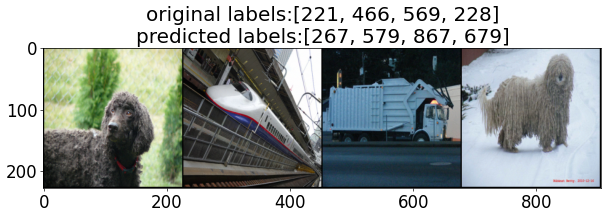

Original labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #1: Irish water spaniel (221)
Image #2: bullet train, bullet (466)
Image #3: garbage truck, dustcart (569)
Image #4: komondor (228)
Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #1: standard poodle (267)
Image #2: grand piano, grand (579)
Image #3: trailer truck, tractor trailer, trucking rig, rig, articulated lorry, semi (867)
Image #4: necklace (679)


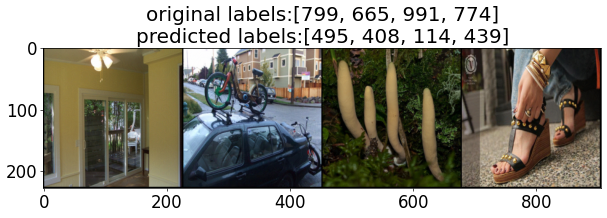

Original labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #5: sliding door (799)
Image #6: moped (665)
Image #7: coral fungus (991)
Image #8: sandal (774)
Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #5: china cabinet, china closet (495)
Image #6: amphibian, amphibious vehicle (408)
Image #7: slug (114)
Image #8: bearskin, busby, shako (439)
[Step #0] Loss: 1.8173 Accuracy: 0.0000% Time elapsed: 3.6504s (total 16 images)
[Step #10] Loss: 1.7483 Accuracy: 0.0000% Time elapsed: 30.8631s (total 176 images)
[Step #20] Loss: 1.7174 Accuracy: 0.0000% Time elapsed: 58.0657s (total 336 images)
[Step #30] Loss: 1.7009 Accuracy: 0.0000% Time elapsed: 85.2558s (total 496 images)
[Step #40] Loss: 1.7167 Accuracy: 0.0000% Time elapsed: 112.4627s (total 656 images)
[Step #50] Loss: 1.7228 Accuracy: 0.0000% Time elapsed: 139.6667s (total 816 images)
[Step #60] Loss: 1.7210 Accuracy: 0.0000% Time elapsed: 166.9023s (total 976 images)
[Step #70] Loss: 1.7129 Accuracy: 0.0000% Time elapsed: 194.1166s (total 1

In [32]:
import time
from advertorch.attacks import LinfPGDAttack

criterion = nn.CrossEntropyLoss()
model.eval()
start_time = time.time()

adversary = LinfPGDAttack(
    model, loss_fn=nn.CrossEntropyLoss(reduction="sum"),
    eps=2/255, nb_iter=7, eps_iter=2/255/4, clip_min=0.0, clip_max=1.0, targeted=False)

running_loss = 0.
running_corrects = 0
running_length = 0

running_l0 = 0
running_l2 = 0
running_mse = 0
running_linf = 0

for i, (inputs, basic_labels) in enumerate(val_dataloader):
    inputs = inputs.to(device)
    labels = torch.zeros_like(basic_labels).long().to(device)
    for j in range(labels.shape[0]):
        labels[j] = int(class_names[basic_labels[j]])
    labels = labels.to(device)

    adv_untargeted = adversary.perturb(inputs, labels) # adversarial attack

    outputs = model(adv_untargeted)
    _, preds = torch.max(outputs, 1)
    loss = criterion(outputs, labels)

    running_loss += loss.item()
    running_corrects += torch.sum(preds == labels.data)
    running_length += labels.shape[0]

    l0, l2, mse, linf = get_distance(adv_untargeted, inputs)
    running_l0 += l0.sum().item()
    running_l2 += l2.sum().item()
    running_mse += mse.sum().item()
    running_linf += linf.sum().item()

    if i == 0:
        print('The dimension of an image tensor:', inputs.shape[1:])
        print('[Prediction Result Examples]')
        images = torchvision.utils.make_grid(adv_untargeted[:4])
        imshow_batch(images.cpu(), title='original labels:' + str([int(x) for x in labels[:4]]) +
                      '\npredicted labels:' + str([int(x) for x in preds[:4]]))
        print('Original labels >>>>>>>>>>>>>>>>>>>>>>>>>')
        for j, imagenet_index in enumerate(labels[:4]):
            label = imagenet_labels[imagenet_index]
            print(f'Image #{j + 1}: {label} ({imagenet_index})')
        print('Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>')
        for j, imagenet_index in enumerate(preds[:4]):
            label = imagenet_labels[imagenet_index]
            print(f'Image #{j + 1}: {label} ({imagenet_index})')
        images = torchvision.utils.make_grid(adv_untargeted[4:8])
        imshow_batch(images.cpu(), title='original labels:' + str([int(x) for x in labels[4:8]]) +
                      '\npredicted labels:' + str([int(x) for x in preds[4:8]]))
        print('Original labels >>>>>>>>>>>>>>>>>>>>>>>>>')
        for j, imagenet_index in enumerate(labels[4:8]):
            label = imagenet_labels[imagenet_index]
            print(f'Image #{j + 5}: {label} ({imagenet_index})')
        print('Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>')
        for j, imagenet_index in enumerate(preds[4:8]):
            label = imagenet_labels[imagenet_index]
            print(f'Image #{j + 5}: {label} ({imagenet_index})')

    if i % 10 == 0:
        cur_running_loss = running_loss / running_length
        running_acc = running_corrects / running_length * 100.
        print('[Step #{}] Loss: {:.4f} Accuracy: {:.4f}% Time elapsed: {:.4f}s (total {} images)'.format(i, cur_running_loss, running_acc, time.time() - start_time, running_length))

epoch_loss = running_loss / len(val_dataset)
epoch_acc = running_corrects / len(val_dataset) * 100.
print('[Validation] Loss: {:.4f} Accuracy: {:.4f}% Time elapsed: {:.4f}s (total {} images)'.format(epoch_loss, epoch_acc, time.time() - start_time, len(val_dataset)))

print('[Size of Perturbation]')
print('Average L0 distance (the number of changed parameters):', running_l0 / len(val_dataset))
print('Average L2 distance:', running_l2 / len(val_dataset))
print('Average MSE:', running_mse / len(val_dataset))
print('Average Linf distance (the maximum changed values):', running_linf / len(val_dataset))

#### <b>Adversarial Attack Example 5</b>

* <b>Attack method</b>: 7-step Linf PGD
* <b>Images</b>: 5,000 valiation images
* <b>Epsilon size</b>: 4 / 255

The dimension of an image tensor: torch.Size([3, 224, 224])
[Prediction Result Examples]


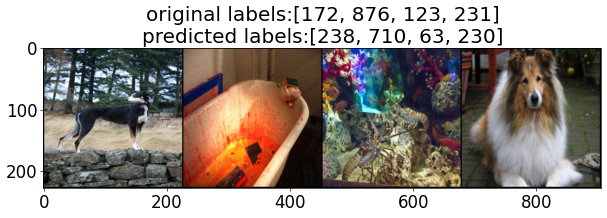

Original labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #1: whippet (172)
Image #2: tub, vat (876)
Image #3: spiny lobster, langouste, rock lobster, crawfish, crayfish, sea crawfish (123)
Image #4: collie (231)
Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #1: Greater Swiss Mountain dog (238)
Image #2: pencil sharpener (710)
Image #3: Indian cobra, Naja naja (63)
Image #4: Shetland sheepdog, Shetland sheep dog, Shetland (230)


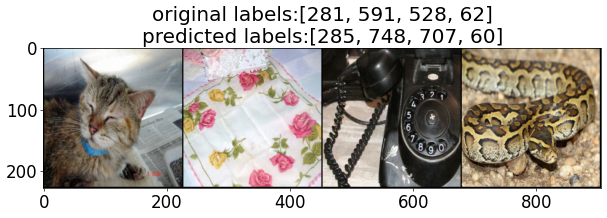

Original labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #5: tabby, tabby cat (281)
Image #6: handkerchief, hankie, hanky, hankey (591)
Image #7: dial telephone, dial phone (528)
Image #8: rock python, rock snake, Python sebae (62)
Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #5: Egyptian cat (285)
Image #6: purse (748)
Image #7: pay-phone, pay-station (707)
Image #8: night snake, Hypsiglena torquata (60)
[Step #0] Loss: 2.1326 Accuracy: 0.0000% Time elapsed: 3.7312s (total 16 images)
[Step #10] Loss: 2.3016 Accuracy: 0.0000% Time elapsed: 30.9775s (total 176 images)
[Step #20] Loss: 2.3060 Accuracy: 0.0000% Time elapsed: 58.2129s (total 336 images)
[Step #30] Loss: 2.3112 Accuracy: 0.0000% Time elapsed: 85.4307s (total 496 images)
[Step #40] Loss: 2.2890 Accuracy: 0.0000% Time elapsed: 112.6483s (total 656 images)
[Step #50] Loss: 2.3167 Accuracy: 0.0000% Time elapsed: 139.8543s (total 816 images)
[Step #60] Loss: 2.3165 Accuracy: 0.0000% Time elapsed: 167.0430s (total 976 images)
[Step #7

In [33]:
import time
from advertorch.attacks import LinfPGDAttack

criterion = nn.CrossEntropyLoss()
model.eval()
start_time = time.time()

adversary = LinfPGDAttack(
    model, loss_fn=nn.CrossEntropyLoss(reduction="sum"),
    eps=4/255, nb_iter=7, eps_iter=4/255/4, clip_min=0.0, clip_max=1.0, targeted=False)

running_loss = 0.
running_corrects = 0
running_length = 0

running_l0 = 0
running_l2 = 0
running_mse = 0
running_linf = 0

for i, (inputs, basic_labels) in enumerate(val_dataloader):
    inputs = inputs.to(device)
    labels = torch.zeros_like(basic_labels).long().to(device)
    for j in range(labels.shape[0]):
        labels[j] = int(class_names[basic_labels[j]])
    labels = labels.to(device)

    adv_untargeted = adversary.perturb(inputs, labels) # adversarial attack

    outputs = model(adv_untargeted)
    _, preds = torch.max(outputs, 1)
    loss = criterion(outputs, labels)

    running_loss += loss.item()
    running_corrects += torch.sum(preds == labels.data)
    running_length += labels.shape[0]

    l0, l2, mse, linf = get_distance(adv_untargeted, inputs)
    running_l0 += l0.sum().item()
    running_l2 += l2.sum().item()
    running_mse += mse.sum().item()
    running_linf += linf.sum().item()

    if i == 0:
        print('The dimension of an image tensor:', inputs.shape[1:])
        print('[Prediction Result Examples]')
        images = torchvision.utils.make_grid(adv_untargeted[:4])
        imshow_batch(images.cpu(), title='original labels:' + str([int(x) for x in labels[:4]]) +
                      '\npredicted labels:' + str([int(x) for x in preds[:4]]))
        print('Original labels >>>>>>>>>>>>>>>>>>>>>>>>>')
        for j, imagenet_index in enumerate(labels[:4]):
            label = imagenet_labels[imagenet_index]
            print(f'Image #{j + 1}: {label} ({imagenet_index})')
        print('Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>')
        for j, imagenet_index in enumerate(preds[:4]):
            label = imagenet_labels[imagenet_index]
            print(f'Image #{j + 1}: {label} ({imagenet_index})')
        images = torchvision.utils.make_grid(adv_untargeted[4:8])
        imshow_batch(images.cpu(), title='original labels:' + str([int(x) for x in labels[4:8]]) +
                      '\npredicted labels:' + str([int(x) for x in preds[4:8]]))
        print('Original labels >>>>>>>>>>>>>>>>>>>>>>>>>')
        for j, imagenet_index in enumerate(labels[4:8]):
            label = imagenet_labels[imagenet_index]
            print(f'Image #{j + 5}: {label} ({imagenet_index})')
        print('Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>')
        for j, imagenet_index in enumerate(preds[4:8]):
            label = imagenet_labels[imagenet_index]
            print(f'Image #{j + 5}: {label} ({imagenet_index})')

    if i % 10 == 0:
        cur_running_loss = running_loss / running_length
        running_acc = running_corrects / running_length * 100.
        print('[Step #{}] Loss: {:.4f} Accuracy: {:.4f}% Time elapsed: {:.4f}s (total {} images)'.format(i, cur_running_loss, running_acc, time.time() - start_time, running_length))

epoch_loss = running_loss / len(val_dataset)
epoch_acc = running_corrects / len(val_dataset) * 100.
print('[Validation] Loss: {:.4f} Accuracy: {:.4f}% Time elapsed: {:.4f}s (total {} images)'.format(epoch_loss, epoch_acc, time.time() - start_time, len(val_dataset)))

print('[Size of Perturbation]')
print('Average L0 distance (the number of changed parameters):', running_l0 / len(val_dataset))
print('Average L2 distance:', running_l2 / len(val_dataset))
print('Average MSE:', running_mse / len(val_dataset))
print('Average Linf distance (the maximum changed values):', running_linf / len(val_dataset))

#### <b>Adversarial Attack Example 6</b>

* <b>Attack method</b>: 7-step Linf PGD
* <b>Images</b>: 5,000 valiation images
* <b>Epsilon size</b>: 8 / 255

The dimension of an image tensor: torch.Size([3, 224, 224])
[Prediction Result Examples]


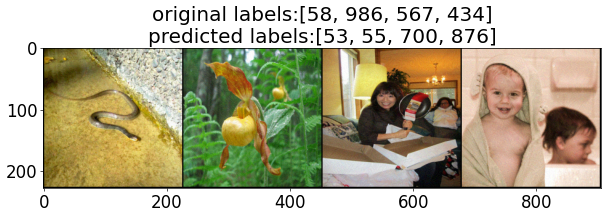

Original labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #1: water snake (58)
Image #2: yellow lady's slipper, yellow lady-slipper, Cypripedium calceolus, Cypripedium parviflorum (986)
Image #3: frying pan, frypan, skillet (567)
Image #4: bath towel (434)
Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #1: ringneck snake, ring-necked snake, ring snake (53)
Image #2: green snake, grass snake (55)
Image #3: paper towel (700)
Image #4: tub, vat (876)


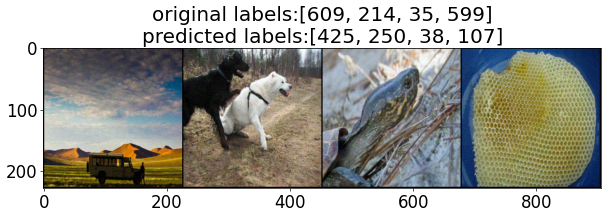

Original labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #5: jeep, landrover (609)
Image #6: Gordon setter (214)
Image #7: mud turtle (35)
Image #8: honeycomb (599)
Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #5: barn (425)
Image #6: Siberian husky (250)
Image #7: banded gecko (38)
Image #8: jellyfish (107)
[Step #0] Loss: 2.9817 Accuracy: 0.0000% Time elapsed: 3.6048s (total 16 images)
[Step #10] Loss: 2.7338 Accuracy: 0.0000% Time elapsed: 30.8597s (total 176 images)
[Step #20] Loss: 2.6769 Accuracy: 0.0000% Time elapsed: 58.1814s (total 336 images)
[Step #30] Loss: 2.6217 Accuracy: 0.0000% Time elapsed: 85.4948s (total 496 images)
[Step #40] Loss: 2.6474 Accuracy: 0.1524% Time elapsed: 112.7501s (total 656 images)
[Step #50] Loss: 2.6407 Accuracy: 0.1225% Time elapsed: 140.0578s (total 816 images)
[Step #60] Loss: 2.6396 Accuracy: 0.1025% Time elapsed: 167.2826s (total 976 images)
[Step #70] Loss: 2.6567 Accuracy: 0.0880% Time elapsed: 194.5198s (total 1136 images)
[Step #80] Loss: 2.66

In [34]:
import time
from advertorch.attacks import LinfPGDAttack

criterion = nn.CrossEntropyLoss()
model.eval()
start_time = time.time()

adversary = LinfPGDAttack(
    model, loss_fn=nn.CrossEntropyLoss(reduction="sum"),
    eps=8/255, nb_iter=7, eps_iter=8/255/4, clip_min=0.0, clip_max=1.0, targeted=False)

running_loss = 0.
running_corrects = 0
running_length = 0

running_l0 = 0
running_l2 = 0
running_mse = 0
running_linf = 0

for i, (inputs, basic_labels) in enumerate(val_dataloader):
    inputs = inputs.to(device)
    labels = torch.zeros_like(basic_labels).long().to(device)
    for j in range(labels.shape[0]):
        labels[j] = int(class_names[basic_labels[j]])
    labels = labels.to(device)

    adv_untargeted = adversary.perturb(inputs, labels) # adversarial attack

    outputs = model(adv_untargeted)
    _, preds = torch.max(outputs, 1)
    loss = criterion(outputs, labels)

    running_loss += loss.item()
    running_corrects += torch.sum(preds == labels.data)
    running_length += labels.shape[0]

    l0, l2, mse, linf = get_distance(adv_untargeted, inputs)
    running_l0 += l0.sum().item()
    running_l2 += l2.sum().item()
    running_mse += mse.sum().item()
    running_linf += linf.sum().item()

    if i == 0:
        print('The dimension of an image tensor:', inputs.shape[1:])
        print('[Prediction Result Examples]')
        images = torchvision.utils.make_grid(adv_untargeted[:4])
        imshow_batch(images.cpu(), title='original labels:' + str([int(x) for x in labels[:4]]) +
                      '\npredicted labels:' + str([int(x) for x in preds[:4]]))
        print('Original labels >>>>>>>>>>>>>>>>>>>>>>>>>')
        for j, imagenet_index in enumerate(labels[:4]):
            label = imagenet_labels[imagenet_index]
            print(f'Image #{j + 1}: {label} ({imagenet_index})')
        print('Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>')
        for j, imagenet_index in enumerate(preds[:4]):
            label = imagenet_labels[imagenet_index]
            print(f'Image #{j + 1}: {label} ({imagenet_index})')
        images = torchvision.utils.make_grid(adv_untargeted[4:8])
        imshow_batch(images.cpu(), title='original labels:' + str([int(x) for x in labels[4:8]]) +
                      '\npredicted labels:' + str([int(x) for x in preds[4:8]]))
        print('Original labels >>>>>>>>>>>>>>>>>>>>>>>>>')
        for j, imagenet_index in enumerate(labels[4:8]):
            label = imagenet_labels[imagenet_index]
            print(f'Image #{j + 5}: {label} ({imagenet_index})')
        print('Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>')
        for j, imagenet_index in enumerate(preds[4:8]):
            label = imagenet_labels[imagenet_index]
            print(f'Image #{j + 5}: {label} ({imagenet_index})')

    if i % 10 == 0:
        cur_running_loss = running_loss / running_length
        running_acc = running_corrects / running_length * 100.
        print('[Step #{}] Loss: {:.4f} Accuracy: {:.4f}% Time elapsed: {:.4f}s (total {} images)'.format(i, cur_running_loss, running_acc, time.time() - start_time, running_length))

epoch_loss = running_loss / len(val_dataset)
epoch_acc = running_corrects / len(val_dataset) * 100.
print('[Validation] Loss: {:.4f} Accuracy: {:.4f}% Time elapsed: {:.4f}s (total {} images)'.format(epoch_loss, epoch_acc, time.time() - start_time, len(val_dataset)))

print('[Size of Perturbation]')
print('Average L0 distance (the number of changed parameters):', running_l0 / len(val_dataset))
print('Average L2 distance:', running_l2 / len(val_dataset))
print('Average MSE:', running_mse / len(val_dataset))
print('Average Linf distance (the maximum changed values):', running_linf / len(val_dataset))

#### <b>Adversarial Attack Example 7</b>

* <b>Attack method</b>: 7-step Linf PGD
* <b>Images</b>: 5,000 valiation images
* <b>Epsilon size</b>: 16 / 255

The dimension of an image tensor: torch.Size([3, 224, 224])
[Prediction Result Examples]


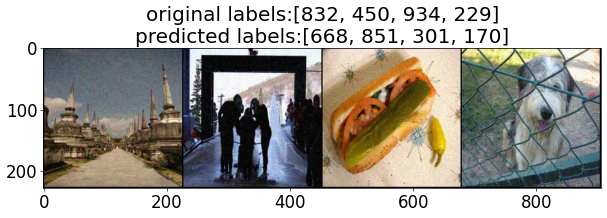

Original labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #1: stupa, tope (832)
Image #2: bobsled, bobsleigh, bob (450)
Image #3: hotdog, hot dog, red hot (934)
Image #4: Old English sheepdog, bobtail (229)
Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #1: mosque (668)
Image #2: television, television system (851)
Image #3: ladybug, ladybeetle, lady beetle, ladybird, ladybird beetle (301)
Image #4: Irish wolfhound (170)


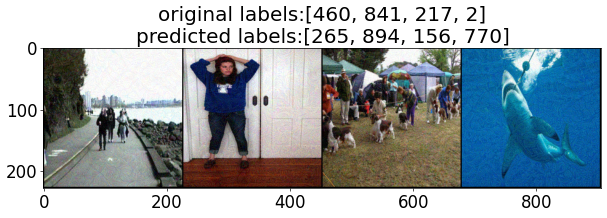

Original labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #5: breakwater, groin, groyne, mole, bulwark, seawall, jetty (460)
Image #6: sweatshirt (841)
Image #7: English springer, English springer spaniel (217)
Image #8: great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias (2)
Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #5: toy poodle (265)
Image #6: wardrobe, closet, press (894)
Image #7: Blenheim spaniel (156)
Image #8: running shoe (770)
[Step #0] Loss: 2.4200 Accuracy: 0.0000% Time elapsed: 3.5609s (total 16 images)
[Step #10] Loss: 2.7334 Accuracy: 0.0000% Time elapsed: 30.8416s (total 176 images)
[Step #20] Loss: 2.7930 Accuracy: 0.0000% Time elapsed: 58.0508s (total 336 images)
[Step #30] Loss: 2.8059 Accuracy: 0.0000% Time elapsed: 85.3078s (total 496 images)
[Step #40] Loss: 2.7973 Accuracy: 0.0000% Time elapsed: 112.5419s (total 656 images)
[Step #50] Loss: 2.7705 Accuracy: 0.0000% Time elapsed: 139.7905s (total 816 images)
[Step #60] Loss: 2.7844 Ac

In [35]:
import time
from advertorch.attacks import LinfPGDAttack

criterion = nn.CrossEntropyLoss()
model.eval()
start_time = time.time()

adversary = LinfPGDAttack(
    model, loss_fn=nn.CrossEntropyLoss(reduction="sum"),
    eps=16/255, nb_iter=7, eps_iter=16/255/4, clip_min=0.0, clip_max=1.0, targeted=False)

running_loss = 0.
running_corrects = 0
running_length = 0

running_l0 = 0
running_l2 = 0
running_mse = 0
running_linf = 0

for i, (inputs, basic_labels) in enumerate(val_dataloader):
    inputs = inputs.to(device)
    labels = torch.zeros_like(basic_labels).long().to(device)
    for j in range(labels.shape[0]):
        labels[j] = int(class_names[basic_labels[j]])
    labels = labels.to(device)

    adv_untargeted = adversary.perturb(inputs, labels) # adversarial attack

    outputs = model(adv_untargeted)
    _, preds = torch.max(outputs, 1)
    loss = criterion(outputs, labels)

    running_loss += loss.item()
    running_corrects += torch.sum(preds == labels.data)
    running_length += labels.shape[0]

    l0, l2, mse, linf = get_distance(adv_untargeted, inputs)
    running_l0 += l0.sum().item()
    running_l2 += l2.sum().item()
    running_mse += mse.sum().item()
    running_linf += linf.sum().item()

    if i == 0:
        print('The dimension of an image tensor:', inputs.shape[1:])
        print('[Prediction Result Examples]')
        images = torchvision.utils.make_grid(adv_untargeted[:4])
        imshow_batch(images.cpu(), title='original labels:' + str([int(x) for x in labels[:4]]) +
                      '\npredicted labels:' + str([int(x) for x in preds[:4]]))
        print('Original labels >>>>>>>>>>>>>>>>>>>>>>>>>')
        for j, imagenet_index in enumerate(labels[:4]):
            label = imagenet_labels[imagenet_index]
            print(f'Image #{j + 1}: {label} ({imagenet_index})')
        print('Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>')
        for j, imagenet_index in enumerate(preds[:4]):
            label = imagenet_labels[imagenet_index]
            print(f'Image #{j + 1}: {label} ({imagenet_index})')
        images = torchvision.utils.make_grid(adv_untargeted[4:8])
        imshow_batch(images.cpu(), title='original labels:' + str([int(x) for x in labels[4:8]]) +
                      '\npredicted labels:' + str([int(x) for x in preds[4:8]]))
        print('Original labels >>>>>>>>>>>>>>>>>>>>>>>>>')
        for j, imagenet_index in enumerate(labels[4:8]):
            label = imagenet_labels[imagenet_index]
            print(f'Image #{j + 5}: {label} ({imagenet_index})')
        print('Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>')
        for j, imagenet_index in enumerate(preds[4:8]):
            label = imagenet_labels[imagenet_index]
            print(f'Image #{j + 5}: {label} ({imagenet_index})')

    if i % 10 == 0:
        cur_running_loss = running_loss / running_length
        running_acc = running_corrects / running_length * 100.
        print('[Step #{}] Loss: {:.4f} Accuracy: {:.4f}% Time elapsed: {:.4f}s (total {} images)'.format(i, cur_running_loss, running_acc, time.time() - start_time, running_length))

epoch_loss = running_loss / len(val_dataset)
epoch_acc = running_corrects / len(val_dataset) * 100.
print('[Validation] Loss: {:.4f} Accuracy: {:.4f}% Time elapsed: {:.4f}s (total {} images)'.format(epoch_loss, epoch_acc, time.time() - start_time, len(val_dataset)))

print('[Size of Perturbation]')
print('Average L0 distance (the number of changed parameters):', running_l0 / len(val_dataset))
print('Average L2 distance:', running_l2 / len(val_dataset))
print('Average MSE:', running_mse / len(val_dataset))
print('Average Linf distance (the maximum changed values):', running_linf / len(val_dataset))

#### <b>Adversarial Attack Example 8</b>

* <b>Attack method</b>: 7-step Linf PGD
* <b>Images</b>: 5,000 valiation images
* <b>Epsilon size</b>: 32 / 255

The dimension of an image tensor: torch.Size([3, 224, 224])
[Prediction Result Examples]


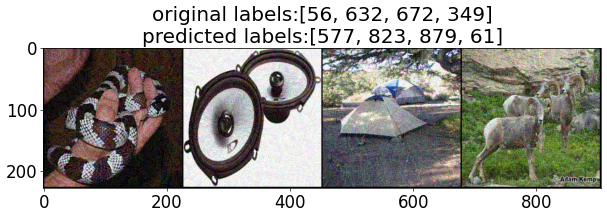

Original labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #1: king snake, kingsnake (56)
Image #2: loudspeaker, speaker, speaker unit, loudspeaker system, speaker system (632)
Image #3: mountain tent (672)
Image #4: bighorn, bighorn sheep, cimarron, Rocky Mountain bighorn, Rocky Mountain sheep, Ovis canadensis (349)
Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #1: gong, tam-tam (577)
Image #2: stethoscope (823)
Image #3: umbrella (879)
Image #4: boa constrictor, Constrictor constrictor (61)


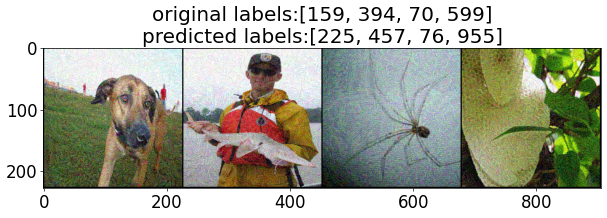

Original labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #5: Rhodesian ridgeback (159)
Image #6: sturgeon (394)
Image #7: harvestman, daddy longlegs, Phalangium opilio (70)
Image #8: honeycomb (599)
Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #5: malinois (225)
Image #6: bow tie, bow-tie, bowtie (457)
Image #7: tarantula (76)
Image #8: jackfruit, jak, jack (955)
[Step #0] Loss: 2.7031 Accuracy: 0.0000% Time elapsed: 3.5402s (total 16 images)
[Step #10] Loss: 2.6926 Accuracy: 0.0000% Time elapsed: 30.7316s (total 176 images)
[Step #20] Loss: 2.6498 Accuracy: 0.0000% Time elapsed: 58.0143s (total 336 images)
[Step #30] Loss: 2.6625 Accuracy: 0.0000% Time elapsed: 85.2238s (total 496 images)
[Step #40] Loss: 2.6837 Accuracy: 0.0000% Time elapsed: 112.4973s (total 656 images)
[Step #50] Loss: 2.6958 Accuracy: 0.0000% Time elapsed: 139.6919s (total 816 images)
[Step #60] Loss: 2.6950 Accuracy: 0.0000% Time elapsed: 166.9536s (total 976 images)
[Step #70] Loss: 2.6956 Accuracy: 0.0000% Time elap

In [36]:
import time
from advertorch.attacks import LinfPGDAttack

criterion = nn.CrossEntropyLoss()
model.eval()
start_time = time.time()

adversary = LinfPGDAttack(
    model, loss_fn=nn.CrossEntropyLoss(reduction="sum"),
    eps=32/255, nb_iter=7, eps_iter=32/255/4, clip_min=0.0, clip_max=1.0, targeted=False)

running_loss = 0.
running_corrects = 0
running_length = 0

running_l0 = 0
running_l2 = 0
running_mse = 0
running_linf = 0

for i, (inputs, basic_labels) in enumerate(val_dataloader):
    inputs = inputs.to(device)
    labels = torch.zeros_like(basic_labels).long().to(device)
    for j in range(labels.shape[0]):
        labels[j] = int(class_names[basic_labels[j]])
    labels = labels.to(device)

    adv_untargeted = adversary.perturb(inputs, labels) # adversarial attack

    outputs = model(adv_untargeted)
    _, preds = torch.max(outputs, 1)
    loss = criterion(outputs, labels)

    running_loss += loss.item()
    running_corrects += torch.sum(preds == labels.data)
    running_length += labels.shape[0]

    l0, l2, mse, linf = get_distance(adv_untargeted, inputs)
    running_l0 += l0.sum().item()
    running_l2 += l2.sum().item()
    running_mse += mse.sum().item()
    running_linf += linf.sum().item()

    if i == 0:
        print('The dimension of an image tensor:', inputs.shape[1:])
        print('[Prediction Result Examples]')
        images = torchvision.utils.make_grid(adv_untargeted[:4])
        imshow_batch(images.cpu(), title='original labels:' + str([int(x) for x in labels[:4]]) +
                      '\npredicted labels:' + str([int(x) for x in preds[:4]]))
        print('Original labels >>>>>>>>>>>>>>>>>>>>>>>>>')
        for j, imagenet_index in enumerate(labels[:4]):
            label = imagenet_labels[imagenet_index]
            print(f'Image #{j + 1}: {label} ({imagenet_index})')
        print('Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>')
        for j, imagenet_index in enumerate(preds[:4]):
            label = imagenet_labels[imagenet_index]
            print(f'Image #{j + 1}: {label} ({imagenet_index})')
        images = torchvision.utils.make_grid(adv_untargeted[4:8])
        imshow_batch(images.cpu(), title='original labels:' + str([int(x) for x in labels[4:8]]) +
                      '\npredicted labels:' + str([int(x) for x in preds[4:8]]))
        print('Original labels >>>>>>>>>>>>>>>>>>>>>>>>>')
        for j, imagenet_index in enumerate(labels[4:8]):
            label = imagenet_labels[imagenet_index]
            print(f'Image #{j + 5}: {label} ({imagenet_index})')
        print('Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>')
        for j, imagenet_index in enumerate(preds[4:8]):
            label = imagenet_labels[imagenet_index]
            print(f'Image #{j + 5}: {label} ({imagenet_index})')

    if i % 10 == 0:
        cur_running_loss = running_loss / running_length
        running_acc = running_corrects / running_length * 100.
        print('[Step #{}] Loss: {:.4f} Accuracy: {:.4f}% Time elapsed: {:.4f}s (total {} images)'.format(i, cur_running_loss, running_acc, time.time() - start_time, running_length))

epoch_loss = running_loss / len(val_dataset)
epoch_acc = running_corrects / len(val_dataset) * 100.
print('[Validation] Loss: {:.4f} Accuracy: {:.4f}% Time elapsed: {:.4f}s (total {} images)'.format(epoch_loss, epoch_acc, time.time() - start_time, len(val_dataset)))

print('[Size of Perturbation]')
print('Average L0 distance (the number of changed parameters):', running_l0 / len(val_dataset))
print('Average L2 distance:', running_l2 / len(val_dataset))
print('Average MSE:', running_mse / len(val_dataset))
print('Average Linf distance (the maximum changed values):', running_linf / len(val_dataset))

#### <b>Comparison with Foolbox</b>

* <b>Attack method</b>: 7-step Linf PGD
* <b>Images</b>: 5,000 valiation images
* <b>Epsilon size</b>: 1 / 255

The dimension of an image tensor: torch.Size([3, 224, 224])
[Prediction Result Examples]


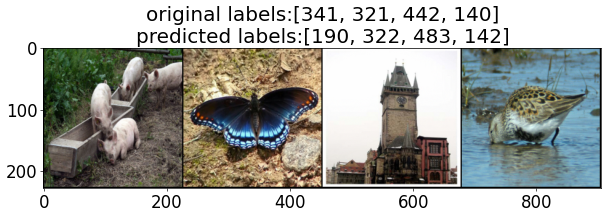

Original labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #1: hog, pig, grunter, squealer, Sus scrofa (341)
Image #2: admiral (321)
Image #3: bell cote, bell cot (442)
Image #4: red-backed sandpiper, dunlin, Erolia alpina (140)
Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #1: Sealyham terrier, Sealyham (190)
Image #2: ringlet, ringlet butterfly (322)
Image #3: castle (483)
Image #4: dowitcher (142)


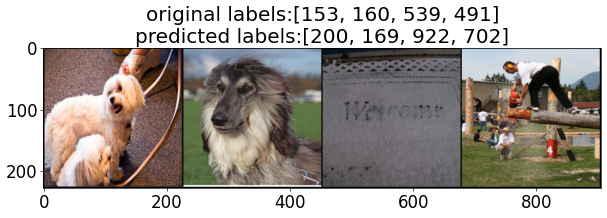

Original labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #5: Maltese dog, Maltese terrier, Maltese (153)
Image #6: Afghan hound, Afghan (160)
Image #7: doormat, welcome mat (539)
Image #8: chain saw, chainsaw (491)
Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #5: Tibetan terrier, chrysanthemum dog (200)
Image #6: borzoi, Russian wolfhound (169)
Image #7: menu (922)
Image #8: parallel bars, bars (702)
[Step #0] Loss: 1.0320 Accuracy: 0.0000% Time elapsed: 3.7590s (total 16 images)
[Step #10] Loss: 1.0484 Accuracy: 0.5682% Time elapsed: 32.1226s (total 176 images)
[Step #20] Loss: 1.0994 Accuracy: 0.5952% Time elapsed: 60.4843s (total 336 images)
[Step #30] Loss: 1.1214 Accuracy: 1.0081% Time elapsed: 88.8470s (total 496 images)
[Step #40] Loss: 1.1214 Accuracy: 0.7622% Time elapsed: 117.2092s (total 656 images)
[Step #50] Loss: 1.1053 Accuracy: 0.6127% Time elapsed: 145.5665s (total 816 images)
[Step #60] Loss: 1.1122 Accuracy: 0.7172% Time elapsed: 173.9242s (total 976 images)
[Step #70] Lo

In [37]:
import time
import foolbox as fb

criterion = nn.CrossEntropyLoss()
model.eval()
start_time = time.time()

fmodel = fb.PyTorchModel(model, bounds=(0, 1))
attack = fb.attacks.LinfProjectedGradientDescentAttack(abs_stepsize=1/255/4, steps=7)

running_loss = 0.
running_corrects = 0
running_length = 0

running_l0 = 0
running_l2 = 0
running_mse = 0
running_linf = 0

for i, (inputs, basic_labels) in enumerate(val_dataloader):
    inputs = inputs.to(device)
    labels = torch.zeros_like(basic_labels).long().to(device)
    for j in range(labels.shape[0]):
        labels[j] = int(class_names[basic_labels[j]])
    labels = labels.to(device)

    _, adv_untargeted, _ = attack(fmodel, inputs, labels, epsilons=1/255) # adversarial attack

    outputs = model(adv_untargeted)
    _, preds = torch.max(outputs, 1)
    loss = criterion(outputs, labels)

    running_loss += loss.item()
    running_corrects += torch.sum(preds == labels.data)
    running_length += labels.shape[0]

    l0, l2, mse, linf = get_distance(adv_untargeted, inputs)
    running_l0 += l0.sum().item()
    running_l2 += l2.sum().item()
    running_mse += mse.sum().item()
    running_linf += linf.sum().item()

    if i == 0:
        print('The dimension of an image tensor:', inputs.shape[1:])
        print('[Prediction Result Examples]')
        images = torchvision.utils.make_grid(adv_untargeted[:4])
        imshow_batch(images.cpu(), title='original labels:' + str([int(x) for x in labels[:4]]) +
                      '\npredicted labels:' + str([int(x) for x in preds[:4]]))
        print('Original labels >>>>>>>>>>>>>>>>>>>>>>>>>')
        for j, imagenet_index in enumerate(labels[:4]):
            label = imagenet_labels[imagenet_index]
            print(f'Image #{j + 1}: {label} ({imagenet_index})')
        print('Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>')
        for j, imagenet_index in enumerate(preds[:4]):
            label = imagenet_labels[imagenet_index]
            print(f'Image #{j + 1}: {label} ({imagenet_index})')
        images = torchvision.utils.make_grid(adv_untargeted[4:8])
        imshow_batch(images.cpu(), title='original labels:' + str([int(x) for x in labels[4:8]]) +
                      '\npredicted labels:' + str([int(x) for x in preds[4:8]]))
        print('Original labels >>>>>>>>>>>>>>>>>>>>>>>>>')
        for j, imagenet_index in enumerate(labels[4:8]):
            label = imagenet_labels[imagenet_index]
            print(f'Image #{j + 5}: {label} ({imagenet_index})')
        print('Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>')
        for j, imagenet_index in enumerate(preds[4:8]):
            label = imagenet_labels[imagenet_index]
            print(f'Image #{j + 5}: {label} ({imagenet_index})')

    if i % 10 == 0:
        cur_running_loss = running_loss / running_length
        running_acc = running_corrects / running_length * 100.
        print('[Step #{}] Loss: {:.4f} Accuracy: {:.4f}% Time elapsed: {:.4f}s (total {} images)'.format(i, cur_running_loss, running_acc, time.time() - start_time, running_length))

epoch_loss = running_loss / len(val_dataset)
epoch_acc = running_corrects / len(val_dataset) * 100.
print('[Validation] Loss: {:.4f} Accuracy: {:.4f}% Time elapsed: {:.4f}s (total {} images)'.format(epoch_loss, epoch_acc, time.time() - start_time, len(val_dataset)))

print('[Size of Perturbation]')
print('Average L0 distance (the number of changed parameters):', running_l0 / len(val_dataset))
print('Average L2 distance:', running_l2 / len(val_dataset))
print('Average MSE:', running_mse / len(val_dataset))
print('Average Linf distance (the maximum changed values):', running_linf / len(val_dataset))